In [2]:
import tensorflow as tf
from tensorflow.keras import layers, Model

import matplotlib.pyplot as plt

In [3]:
class Tanh(Model):
  def call(self, x):
    return 2 / (1  + tf.exp(-2*x)) -1

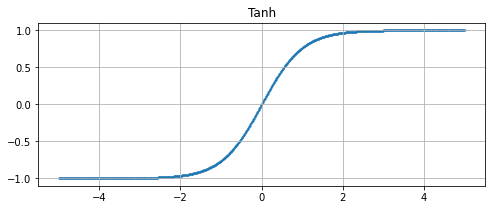

In [4]:
x = tf.linspace(-5, 5, 1000)
y = Tanh()(x)

plt.figure(figsize = (8,3))
plt.title("Tanh")
plt.scatter(x, y, s = 1)
plt.grid()
plt.show()

In [5]:
class Dense(Model):
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.w = tf.random.normal(shape = (input_dim, output_dim))
    self.b = tf.zeros(shape = (output_dim))
  
  def __call__(self, x):
    # y = tf.matmul(x,self.w) + self.b
    y = x @ self.w + self.b
    return y
    

In [6]:
t = tf.random.normal((2,256))
t = Dense(256, 512)(t)
print(t.shape)



(2, 512)


### RNN 구현

$h^{\prime}=\tanh \left(W_{i h} x+b_{i h}+W_{h h} h+b_{h h}\right)$

In [7]:
class RNNCell(Model):
  def __init__(self, input_dim, hidden_dim, activation = Tanh):
    super().__init__()
    self.dense1 = Dense(hidden_dim, hidden_dim)
    self.dense2 = Dense(input_dim, hidden_dim)
    self.activation = activation()
  
  def call(self, x, h):
    h = self.dense2(x) + self.dense1(h)
    h = self.activation(h)
    return h


In [8]:
x = tf.random.normal((2,16))
h = tf.random.normal((2,32))

y = RNNCell(16,32)(x,h)
print(y.shape)

(2, 32)


### RNN 구현

RNN는 RNNCell을 sub-layer로 갖고 있습니다.

forward pass를 구현하는 call에서 for loop 통해 매 time step의 vector를 RNNCell에 넣고 hidden state를 출력합니다.

출력된 hidden state는 다음 time step의 hidden state 입력으로 들어갑니다.

첫번째 time step에서는 주어진 hidden state가 없으므로 tf.zeros를 이용하여 0으로 채운 벡터를 사용합니다.

모든 time step의 출력은 for loop이 끝난 뒤, tf.stack 명령을 통해 쌓아서 최종 출력으로 만듭니다.

In [9]:
class RNN(Model):
  def __init__(self, input_dim, hidden_dim, activation = Tanh):
    super().__init__()
    self.hidden_dim = hidden_dim
    self.rnn_cell = RNNCell(input_dim, hidden_dim, activation)
  
  def call(self, x):
    # x(batch, length, input_dim)
    batch, length, input_dim = x.shape
  
    h = tf.zeros(shape = (batch, self.hidden_dim)) #초기화
    y = [] # stack list

    for l in range(length): # time step
      #batch ,1, input_dim
      x_ = x[:,l,:]
      h = self.rnn_cell(x_, h)
      y.append(h)
    
    y = tf.stack(y, axis = 1) # axis =1 -> stack by length
    return y



In [10]:
x = tf.random.normal((2, 100 ,16))

y = RNN(16, 32)(x)
print(y.shape)

(2, 100, 32)


### GRUCell을 구현

\begin{aligned}
&r=\sigma\left(W_{i r} x+b_{i r}+W_{h r} h+b_{h r}\right) \\
&z=\sigma\left(W_{i z} x+b_{i z}+W_{h z} h+b_{h z}\right) \\
&n=\tanh \left(W_{i n} x+b_{i n}+r *\left(W_{h n} h+b_{h n}\right)\right) \\
&h^{\prime}=(1-z) * n+z * h
\end{aligned}

In [11]:
class Sigmoid(Model):
    def call(self, x):
        return 1 / (1 + tf.exp(-x))

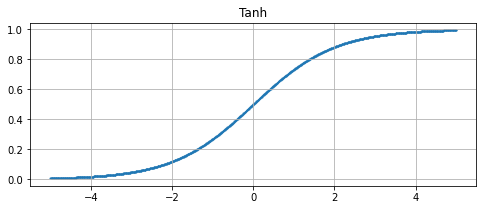

In [12]:
x = tf.linspace(-5, 5, 1000)
y = Sigmoid()(x)

plt.figure(figsize=[8, 3])
plt.title('Tanh')
plt.scatter(x, y, s=1)
plt.grid()
plt.show()

In [13]:
class GRUCell(Model):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.dense_1 = Dense(input_dim, hidden_dim)
        self.dense_2 = Dense(hidden_dim, hidden_dim)
        self.dense_3 = Dense(input_dim, hidden_dim)
        self.dense_4 = Dense(hidden_dim, hidden_dim)
        self.dense_5 = Dense(input_dim, hidden_dim)
        self.dense_6 = Dense(hidden_dim, hidden_dim)
        self.sigmoid = Sigmoid()
        self.tanh = Tanh()

    def call(self, x, h):
        r = self.sigmoid(self.dense_1(x) + self.dense_2(h))
        z = self.sigmoid(self.dense_3(x) + self.dense_4(h))
        n = self.tanh(self.dense_5(x) + r*(self.dense_6(h)))
        h_hat = (1-z)*n + z * h
        return h_hat
        
    

In [14]:
class GRUCell(Model):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.dense_1 = Dense(input_dim, hidden_dim)
        self.dense_2 = Dense(hidden_dim, hidden_dim)
        
        self.sigmoid = Sigmoid()
        self.tanh = Tanh()

    def call(self, x, h):
        r = self.sigmoid(self.dense_1(x) + self.dense_2(h))
        z = self.sigmoid(self.dense_1(x) + self.dense_2(h))
        n = self.tanh(self.dense_1(x) + r*(self.dense_2(h)))
        h_hat = (1-z)*n + z * h
        return h_hat
        
    

In [15]:
x = tf.random.normal((2,16))
h = tf.random.normal((2,32))

y = GRUCell(16,32)(x,h)
print(y.shape)

(2, 32)


In [16]:
class GRU(Model):
  def __init__(self, input_dim, hidden_dim):
    super().__init__()
    self.hidden_dim = hidden_dim
    self.gru_cell = GRUCell(input_dim, hidden_dim)
  
  def call(self, x):
    # x(batch, length, input_dim)
    batch, length, input_dim = x.shape
  
    h = tf.zeros(shape = (batch, self.hidden_dim)) #초기화
    y = [] # stack list

    for l in range(length): # time step
      #batch ,1, input_dim
      x_ = x[:,l,:]
      h = self.gru_cell(x_, h)
      y.append(h)
    
    y = tf.stack(y, axis = 1) # axis =1 -> stack by length
    return y


In [17]:
x = tf.random.normal((2, 100 ,16))

y = RNN(16, 32)(x)
print(y.shape)

(2, 100, 32)


In [21]:
class LSTMCell(Model):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.sigmoid = Sigmoid()
        self.tanh = Tanh()
        self.dense = Dense(input_dim + hidden_dim, hidden_dim*4)
    
    def call(self, x, state):
        # x : (batch, input_dim)
        # state : (batch, hidden_dim), (batch, hidden_dim)
        h, c = state

        # (batch, input_dim + hidden_dim)
        xh = np.concatenate([x, h], axis=1)

        # (batch , hidden_dim *4)
        d = self.dense(xh)

        # (batch, hidden_dim), (batch, hidden_dim), (batch, hidden_dim), (batch, hidden_dim)
        i, f, g, o = tf.split(d, 4, axis=1)

        i = self.sigmoid(i)
        f = self.sigmoid(f)
        g = self.tanh(g)
        o = self.sigmoid(o)
        c_ = f*c + i*g
        h_ = o*self.tanh(c_)

        return h_, c_
        

In [22]:
class LSTM:
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.lstm_cell = LSTMCell(input_dim, hidden_dim)
    
    def __call__(self, x):
        # x : (batch, length, input_dim)
        batch, length, input_dim = x.shape

        h = tf.zeros((batch, self.hidden_dim)) # 초기 벡터를 0으로 초기화한다.
        c = tf.zeros((batch, self.hidden_dim))
        y = [] # 결과를 저장할 곳을 초기화 (빈 리스트)
        for l in range(length): # timestep으로 loop
            # batch, length, input_dim
            x_ = x[:, l, :]
            h,c = self.lstm_cell(x_, (h,c))
            y.append(h)
        y = tf.stack(y, axis=1)
        return y 

In [25]:
x = tf.random.normal((2, 100, 16))
y = LSTM(16, 32)(x)
print(y.shape)

(2, 100, 32)


#RNN으로 소설 생성하기

In [24]:
import tensorflow as tf

import numpy as np
import os
import time

In [26]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')
print(path_to_file)

1130496/1115394 [==============================] - 0s 0us/step
/root/.keras/datasets/shakespeare.txt


In [28]:
line = ' 하이 '
line.strip()

'하이'

In [29]:
with open(path_to_file, 'r') as f:
    lines = f.readlines()
for line in lines:
    print(line.rstrip())

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Page:
My lord, 'tis but begun.

SLY:
'Tis a very excellent piece of work, madam lady:
would 'twere done!

PETRUCHIO:
Verona, for a while I take my leave,
To see my friends in Padua, but of all
My best beloved and approved friend,
Hortensio; and I trow this is his house.
Here, sirrah Grumio; knock, I say.

GRUMIO:
Knock, sir! whom should I knock? is there man has
rebused your worship?

PETRUCHIO:
Villain, I say, knock me here soundly.

GRUMIO:
Knock you here, sir! why, sir, what am I, sir, that
I should knock you here, sir?

PETRUCHIO:
Villain, I say, knock me at this gate
And rap me well, or I'll knock your knave's pate.

GRUMIO:
My master is grown quarrelsome. I should knock
you first,
And then I know after who comes by the worst.

PETRUCHIO:
Will it not be?
Faith, sirrah, an you'll not knock, I'll ring it;
I'll try how you can sol, fa, and sing it.

GRUMIO:
Help, masters, help! my master is mad.

PETRUCHIO:
Now, knock when I bid you, sirrah villain

### 데이터 읽기

In [31]:
text = open(path_to_file, 'rb').read().decode(encoding = 'utf-8')

print(" Length of Text : {}".format(len(text)))

 Length of Text : 1115394


In [32]:
vocab = sorted(set(text)) # 중복제거
print(f"고유 문자 수 {len(vocab)}")

고유 문자 수 65


### 텍스트 벡터화

In [33]:
for i, u in enumerate(vocab):
  print(i,":",u)

0 : 

1 :  
2 : !
3 : $
4 : &
5 : '
6 : ,
7 : -
8 : .
9 : 3
10 : :
11 : ;
12 : ?
13 : A
14 : B
15 : C
16 : D
17 : E
18 : F
19 : G
20 : H
21 : I
22 : J
23 : K
24 : L
25 : M
26 : N
27 : O
28 : P
29 : Q
30 : R
31 : S
32 : T
33 : U
34 : V
35 : W
36 : X
37 : Y
38 : Z
39 : a
40 : b
41 : c
42 : d
43 : e
44 : f
45 : g
46 : h
47 : i
48 : j
49 : k
50 : l
51 : m
52 : n
53 : o
54 : p
55 : q
56 : r
57 : s
58 : t
59 : u
60 : v
61 : w
62 : x
63 : y
64 : z


In [34]:
for c in text[:100]:
  print(c)

F
i
r
s
t
 
C
i
t
i
z
e
n
:


B
e
f
o
r
e
 
w
e
 
p
r
o
c
e
e
d
 
a
n
y
 
f
u
r
t
h
e
r
,
 
h
e
a
r
 
m
e
 
s
p
e
a
k
.




A
l
l
:


S
p
e
a
k
,
 
s
p
e
a
k
.




F
i
r
s
t
 
C
i
t
i
z
e
n
:


Y
o
u


In [37]:
# 고유 문자에서 인덱스로 매핑 생성
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

print(len(text_as_int))
print(text_as_int[:50])

1115394
[18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 14 43 44 53 56 43  1 61 43
  1 54 56 53 41 43 43 42  1 39 52 63  1 44 59 56 58 46 43 56  6  1 46 43
 39 56]


In [39]:
print('{')
for char,_ in zip(char2idx, range(20)):
  print('{:4s} : {:3d}'.format(repr(char), char2idx[char]))
print(' ...\n')

{
'\n' :   0
' '  :   1
'!'  :   2
'$'  :   3
'&'  :   4
"'"  :   5
','  :   6
'-'  :   7
'.'  :   8
'3'  :   9
':'  :  10
';'  :  11
'?'  :  12
'A'  :  13
'B'  :  14
'C'  :  15
'D'  :  16
'E'  :  17
'F'  :  18
'G'  :  19
 ...



In [44]:
# 텍스트에서 처음 13개의 문자가 숫자로 어떻게 매핑되었는지 봅시다.
print('{} ---- 문자들이 다음의 정수로 매핑되었습니다 ---- > {}'.format(repr(text[:13]), text_as_int[:13]))

'First Citizen' ---- 문자들이 다음의 정수로 매핑되었습니다 ---- > [18 47 56 57 58  1 15 47 58 47 64 43 52]


###훈련 샘플과 타겟 만들기

In [47]:
#단일 입력에 대해 원하는 문장의 최대 길이
seq_length = 100
examples_per_epoch = len(text) // seq_length

#훈련샘플/타겟 만들기
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int) #텍스트 벡터 -> 문자 인덱스 스트림으로 변환

for i in char_dataset.take(5):
  print(idx2char[i.numpy()])

F
i
r
s
t


In [51]:
sequences = char_dataset.batch(seq_length+1, drop_remainder = True)
# batch : 개별 문자들을 원하는 크기의 시퀀스로 쉽게 변환 할 수 있다. 

for item in sequences.take(5):
  print(repr(''.join(idx2char[item.numpy()])))

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [53]:
string = 'First Citizen'
print(string[:-1])
print(string[1:])

First Citize
irst Citizen


In [54]:
def split_input_target(chunk):
  input_text = chunk[:-1]
  target_text = chunk[1:]
  return input_text, target_text

dataset = sequences.map(split_input_target)
#map : 각 배치에 간단한 함수를 적용하고 입력 텍스트와 타깃 텍스트를 복사 및 이동


In [58]:
#Print First Sample Data

for input_example, target_example in dataset.take(1):
  print("Input Data : ",repr(''.join(idx2char[input_example.numpy()])))
  print("Target Data : ",repr(''.join(idx2char[target_example.numpy()])))

Input Data :  'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target Data :  'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


In [62]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
  print(f"{i:4d} 단계")
  print(f"Input {input_idx} ({repr(idx2char[input_idx]):s})")
  print(f"Pred {target_idx} ({repr(idx2char[target_idx]):s})\n")

   0 단계
Input 18 ('F')
Pred 47 ('i')

   1 단계
Input 47 ('i')
Pred 56 ('r')

   2 단계
Input 56 ('r')
Pred 57 ('s')

   3 단계
Input 57 ('s')
Pred 58 ('t')

   4 단계
Input 58 ('t')
Pred 1 (' ')



### 훈련 배치 생성

In [63]:
BATCH_SIZE = 64

# 데이터셋을 섞을 버퍼 크기
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

### 모델설계

In [64]:
class Embedding:
  def __init__(self, input_dim, output_dim):
    self.table = np.random.randn(input_dim, output_dim)
  
  def __call__(self, x):
    # x : (batch, length) int
    batch, length = x.shape
    x = x.flatten()
    # (batch * length, output_dim)
    y = self.table[x]
    # (batch * length, output_dim)
    y = y.reshape(batch, length, -1)

    return y

In [65]:
len(vocab)

65

In [66]:
x = np.random.randint(0, len(vocab), size = (3,100))
embedding = Embedding(len(vocab), 512)
y = embedding(x)
print(y.shape)

(3, 100, 512)


In [71]:
# 문자로 된 어휘 사전의 크기
vocab_size = len(vocab)
print(vocab_size)

# 임베딩 차원
embedding_dim = 256

# RNN 갯수
rnn_units = 1024

65


In [135]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
                                 tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),
                                 tf.keras.layers.LSTM(rnn_units, return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform'),
                                 tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [136]:
model = build_model(vocab_size = len(vocab),
                    embedding_dim = embedding_dim,
                    rnn_units = rnn_units,
                    batch_size = BATCH_SIZE)

###모델 사용

In [137]:
# 출력 형태 살펴보기
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape)

(64, 100, 65)


In [138]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (64, None, 256)           16640     
                                                                 
 lstm_4 (LSTM)               (64, None, 1024)          5246976   
                                                                 
 dense_17 (Dense)            (64, None, 65)            66625     
                                                                 
Total params: 5,330,241
Trainable params: 5,330,241
Non-trainable params: 0
_________________________________________________________________


In [139]:
# 배치의 첫 번째 샘플링
example_batch_predictions[0].shape

TensorShape([100, 65])

In [140]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
print(sampled_indices.shape)
sampled_indices= tf.squeeze(sampled_indices, axis = -1).numpy()
print(sampled_indices.shape)

(100, 1)
(100,)


In [141]:
sampled_indices

array([51, 34, 23, 64,  2, 23, 20, 59, 19, 60, 40, 43,  2, 25, 28, 41, 60,
       41, 20, 40, 30, 50, 47,  6, 44, 36, 15, 60, 45, 35, 14, 46, 61, 54,
       45, 16, 14,  3, 33, 14, 15, 49, 23, 50, 18, 23, 46, 26, 62, 18, 40,
        1, 58, 37,  3,  6, 19, 50, 21, 64,  9, 35,  1, 32, 56, 43,  5, 11,
        4, 21,  9,  3, 31, 57, 49, 42, 38, 26, 56, 62, 40, 11, 31, 53, 35,
       49, 61, 36, 56, 45,  5, 19, 35, 47,  2, 62,  8, 53, 14, 34])

In [142]:
print("입력 : \n", repr("".join(idx2char[input_example_batch[0]])))
print("\n예측된 다음 문자 : \n", repr("".join(idx2char[sampled_indices])))

입력 : 
 "made the belly?\n\nMENENIUS:\nSir, I shall tell you. With a kind of smile,\nWhich ne'er came from the lu"

예측된 다음 문자 : 
 "mVKz!KHuGvbe!MPcvcHbRli,fXCvgWBhwpgDB$UBCkKlFKhNxFb tY$,GlIz3W Tre';&I3$SskdZNrxb;SoWkwXrg'GWi!x.oBV"


In [143]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits = True)

In [144]:
example_batch_loss = loss(target_example_batch, example_batch_predictions)
print("예측 배열 크기(shape) :", example_batch_predictions.shape) 
print("스칼라 손실 :", example_batch_loss.numpy().mean())

예측 배열 크기(shape) : (64, 100, 65)
스칼라 손실 : 4.175228


In [145]:
model.compile(optimizer = 'adam', loss = loss)

In [146]:
# 체크포인트가 저장될 디렉토리
checkpoint_dir = './training_checkpoints'
# 체크포인트 파일 이름
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [147]:
Epoch = 30
history = model.fit(dataset, epochs=Epoch, callbacks=  [checkpoint_callback])

Epoch 1/30
172/172 [==============================] - 34s 176ms/step - loss: 2.5969
Epoch 2/30
172/172 [==============================] - 32s 176ms/step - loss: 1.8879
Epoch 3/30
172/172 [==============================] - 32s 175ms/step - loss: 1.6391
Epoch 4/30
172/172 [==============================] - 32s 176ms/step - loss: 1.5061
Epoch 5/30
172/172 [==============================] - 32s 175ms/step - loss: 1.4253
Epoch 6/30
172/172 [==============================] - 32s 176ms/step - loss: 1.3684
Epoch 7/30
172/172 [==============================] - 32s 175ms/step - loss: 1.3222
Epoch 8/30
172/172 [==============================] - 32s 175ms/step - loss: 1.2847
Epoch 9/30
172/172 [==============================] - 32s 175ms/step - loss: 1.2480
Epoch 10/30
172/172 [==============================] - 32s 175ms/step - loss: 1.2136
Epoch 11/30
172/172 [==============================] - 32s 175ms/step - loss: 1.1786
Epoch 12/30
172/172 [==============================] - 32s 175ms/step - lo

In [148]:
tf.train.latest_checkpoint(checkpoint_dir)

'./training_checkpoints/ckpt_30'

In [149]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

In [150]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (1, None, 256)            16640     
                                                                 
 lstm_5 (LSTM)               (1, None, 1024)           5246976   
                                                                 
 dense_18 (Dense)            (1, None, 65)             66625     
                                                                 
Total params: 5,330,241
Trainable params: 5,330,241
Non-trainable params: 0
_________________________________________________________________


In [151]:
def generate_text(model, start_string):
  #평가 단계

  #생성할 문자의 수
  num_generate = 1000

  #시작 문자열을 숫자로 변환(벡터화)
  input_eval = [char2idx[s] for s in start_string]
  #(1, len(start_string))
  input_eval = tf.expand_dims(input_eval, 0)

  #결과 저장
  text_generated = []
  
  #온도가 낮으면 더 예측 가능한 텍스트가 되고
  #온도가 높으면 더 의외의 텍스트가 된다.
  #최적의 세팅을 찾기위한 세팅
  temperature = 1.0

  model.reset_states()
  for i in range(num_generate):
    predictions = model(input_eval)
    #배치 차원 제거
    predictions = tf.squeeze(predictions, 0)

    #범주형 분포를 사용하여 모델에서 리턴한 단어 예측
    predictions = predictions / temperature
    predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

    #예측된 단어를 다음 입력으로 모델에 전달
    #이전 은닉 상태와 함께 
    input_eval = tf.expand_dims([predicted_id],0)

    text_generated.append(idx2char[predicted_id])

  return (start_string + ''.join(text_generated))

In [152]:
print(generate_text(model, start_string = u'ROMEO: '))

ROMEO: 'Sir! Venatory, as I said, AERLENCE:
Be noted but example
Of the true seat in arms: there is thy fault?

KING EDWARD IV:
Brother, tell me, sister, here another and we know she is.
Hark you, sir? his conscience in thee thus.

FLORIZEL:
She may not end am to deny it her.

KING RICHARD II:
Thou wast not what too much, this, come up their courser's back?
But in a swafe, sweet Claudio, d inthrist
My tongue that island sort: if this growth may yield thee marries on you hade.

FRIAR LAURENCE:
Who three! what cheer?

KING RICHARD II:
How here you look on me?

LEONTES:
Let's take leave of thee!
No, had I now give my thing in hatred, and
Lord Burzend of Henry, be that you have not moved.

Poor dross and the threatening slander of your holy like
Revolting that you have left your patience,
I have been freely.

ARIEL OF YORK:
No, if I lie with thee this intextrility
Was timed with Earl of uncreed or thee!
Now Margaret: thou hast deny me passing fair?

FERDIONA:
Good head, o' my authority ben

### Seq2Seq Model

In [194]:
class Encoder(Model):
  def __init__(self, vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.lstm = tf.keras.layers.LSTM(enc_units)
  
  def call(self,x):
    print("Input shape : ",x.shape)

    x = self.embedding(x)
    print("After Embedding : ",x.shape)

    output = self.lstm(x)
    print("After lstm : ",output.shape)
    return output

In [195]:
vocab_size = 30000
emb_size = 256
lstm_size = 512
batch_size = 1
sample_seq_len = 3

print("Vocab Size : {0}".format(vocab_size))
print("Embedding Size : {0}".format(emb_size))
print("LSTM Size : {0}".format(lstm_size))
print("Batch Size : {0}".format(batch_size))
print("Sample Sequence Length : {0}\n".format(sample_seq_len))

Vocab Size : 30000
Embedding Size : 256
LSTM Size : 512
Batch Size : 1
Sample Sequence Length : 3



In [196]:
encoder = Encoder(vocab_size,emb_size,lstm_size)
sample_input = tf.zeros((batch_size,sample_seq_len))

sample_output = encoder(sample_input)

Input shape :  (1, 3)
After Embedding :  (1, 3, 256)
After lstm :  (1, 512)


### LSTM Decoder

In [198]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.LSTM(dec_units, return_sequences= True)
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.softmax = tf.keras.layers.Softmax(axis=-1)

    def call(self, x, context_v):
        print("입력 shape :", x.shape)

        x = self.embedding(x)
        print("Embedding Layer을 거친 shape :", x.shape)

        context_v = tf.repeat(tf.expand_dims(context_v, axis=1), repeats=x.shape[1], axis=1)
        x = tf.concat([x, context_v], axis= -1)
        print("Context Vector가 더해진 shape :", x.shape)

        x = self.lstm(x)
        print("LSTM Layer의 Output layer:", x.shape)

        output = self.fc(x)
        print("Decoder의 최종 Output shape :", output.shape)

        return self.softmax(output)

In [199]:
vocab_size = 30000
emb_size = 256
lstm_size = 512
batch_size = 1
sample_seq_len = 3

print("Vocab Size : {0}".format(vocab_size))
print("Embedding Size : {0}".format(emb_size))
print("LSTM Size : {0}".format(lstm_size))
print("Batch Size : {0}".format(batch_size))
print("Sample Sequence Length : {0}\n".format(sample_seq_len))

Vocab Size : 30000
Embedding Size : 256
LSTM Size : 512
Batch Size : 1
Sample Sequence Length : 3



In [200]:
decoder = Decoder(vocab_size,emb_size,lstm_size)
sample_input = tf.zeros((batch_size,sample_seq_len))

dec_output = decoder(sample_input,sample_output)

입력 shape : (1, 3)
Embedding Layer을 거친 shape : (1, 3, 256)
Context Vector가 더해진 shape : (1, 3, 768)
LSTM Layer의 Output layer: (1, 3, 512)
Decoder의 최종 Output shape : (1, 3, 30000)


In [189]:
a = tf.expand_dims(sample_output,axis =1)

In [190]:
a.shape

TensorShape([1, 1, 512])